In [1]:
from lameg.util import load_meg_sensor_data
import nibabel as nib

In [8]:
from lameg.util import convert_native_to_fsaverage
from lameg.surf import create_surf_gifti
from lameg.viz import show_surface, rgbtoint
from base64 import b64decode
from PIL import Image
import matplotlib.pyplot as plt
import io
import os
import glob
import numpy as np

In [3]:
def upload_meg_file(rawdata_path, sub, ses, condition):
    """
    Search and upload the raw datachunck

    :param rawdata_path: datapath
    :param sub: subjects id
    :param ses: session id 
    :param condition: experimental condition (block-wise)
    """
    
    sub_meg_path = os.path.join(rawdata_path, "sub-" + sub , "ses-0" + ses , "meg/sub-"+ sub + "_ses-0" + ses + "_task-" + condition + "_acq-")
    folders_acq = glob.glob(sub_meg_path + "*_meg.ds", recursive=True)
    list_folders = sorted(folders_acq, key=lambda x: int(x.split('acq-')[1].split('_')[0]))
    
    return list_folders

In [ ]:
subjects=['sub-105', 'sub-107', 'sub-109', 'sub-113', 'sub-114',
           'sub-115', 'sub-117','sub-118','sub-119', 'sub-123', 
           'sub-124', 'sub-126','sub-127','sub-129', 'sub-130',
           'sub-131','sub-132','sub-133','sub-134','sub-135', 
           'sub-136', 'sub-137','sub-138', 'sub-141','sub-142',
           'sub-143','sub-144','sub-145']

sessions = {
    'sub-105': ['ses-01'], 'sub-107': ['ses-01'], 'sub-109': ['ses-01'], 'sub-113': ['ses-01'], 
    'sub-114': ['ses-01'], 'sub-115': ['ses-01'],'sub-117': ['ses-01'], 'sub-118': ['ses-01'], 
    'sub-119': ['ses-01'], 'sub-123': ['ses-01'],'sub-124': ['ses-01'], 'sub-126': ['ses-01'], 
    'sub-127': ['ses-01'], 'sub-129': ['ses-01'],'sub-130': ['ses-01'], 'sub-131': ['ses-01'],
    'sub-132': ['ses-01'], 'sub-133': ['ses-01'],'sub-134': ['ses-01'], 'sub-135': ['ses-01'], 
    'sub-136': ['ses-01'], 'sub-137': ['ses-01'], 'sub-138': ['ses-01'],'sub-141': ['ses-01'], 
    'sub-142': ['ses-01'], 'sub-143': ['ses-01'], 'sub-144': ['ses-01'],
    'sub-145': ['ses-01']
}

n_layers=11
time_lims=[- 300,300]
out_dir=os.path.join('')
braindyn_files = ""
figures_path = ""
meg_rawdata_path = ""

# all_snrs=[]


SUB = ['105', '107', '109', '113', '114',
        '115', '117','118','119', '123', 
        '124', '126','127','129', '130',
        '131','132','133','134', '135', 
        '136', '137','138', '141','142',
        '143','144','145']

ses = "1"
condition = "V100V100"
mxf_option = "no_mxf" 
trigger = "right_stim" # just for SNR computation

snrs_subj = []

for s, sub in enumerate(SUB): 
    
    print(f"Computing part {sub} SNR")

    list_folders = upload_meg_file(meg_rawdata_path, sub, ses, condition)
    mxf_path_dir = os.path.join(list_folders[-1], f"mxf_{mxf_option}_data")

    output_spm_conv_dir = os.path.join(mxf_path_dir, "mxf_sess_data", "spm_convert_epo")
    spm_converted_file = f"spm_sub-{sub}_ses-0{ses}_task-{condition}_meg_{mxf_option}_{trigger}_nrg_ERF_epo"
    base_fname = os.path.join(output_spm_conv_dir,spm_converted_file + ".mat")

    sensor_data, sensor_time, ch_names = load_meg_sensor_data(base_fname)
    st_idx=np.where((sensor_time>=time_lims[0]) & (sensor_time<=time_lims[1]))[0]
    sensor_data=sensor_data[:,st_idx,:]
    sensor_time=sensor_time[st_idx]
    # Compute mean signal across trials (shape: n_channels x n_times)
    mean_signal = np.mean(sensor_data, axis=2)
    # Compute residual noise (trial-by-trial deviations from mean)
    noise = sensor_data - mean_signal[:, :, np.newaxis]
    # Compute RMS of signal and noise over channels
    rms_signal = np.sqrt(np.mean(mean_signal**2, axis=0))  # shape: (n_times,)
    rms_noise = np.sqrt(np.mean(np.mean(noise**2, axis=2), axis=0))  # shape: (n_times,)
    # Compute SNR time series in dB
    snr_db = 20 * np.log10(rms_signal / rms_noise)
    snrs_subj.append(snr_db)

snrs_all = np.array(snrs_subj)
mean_snr_sub = np.mean(snrs_all, axis=1)
thresh_snr = -15
threshold = mean_snr_sub < thresh_snr
exclude_indices = np.where(threshold)[0]
hi_snr_subjects = [item for i, item in enumerate(subjects) if i not in exclude_indices]
lo_snr_subjects = [item for i, item in enumerate(subjects) if i in exclude_indices]


Computing part 105 SNR
Computing part 107 SNR
Computing part 109 SNR
Computing part 113 SNR
Computing part 114 SNR
Computing part 115 SNR
Computing part 117 SNR
Computing part 118 SNR
Computing part 119 SNR
Computing part 123 SNR
Computing part 124 SNR
Computing part 126 SNR
Computing part 127 SNR
Computing part 129 SNR
Computing part 130 SNR
Computing part 131 SNR
Computing part 132 SNR
Computing part 133 SNR
Computing part 134 SNR
Computing part 135 SNR
Computing part 136 SNR
Computing part 137 SNR
Computing part 138 SNR
Computing part 141 SNR
Computing part 142 SNR
Computing part 143 SNR
Computing part 144 SNR
Computing part 145 SNR


In [ ]:
# plot the left hemisphere - ipsi contra attention conditions

fsave_lh_coords, fsave_lh_faces = nib.freesurfer.io.read_geometry('.../fsaverage/surf/lh.inflated')
fsave_lh = create_surf_gifti(fsave_lh_coords, fsave_lh_faces)
lh_curv_data = nib.freesurfer.read_morph_data('.../fsaverage/surf/lh.curv')

subj_coords_lh_la={
    subject: [] for subject in hi_snr_subjects
}

subj_coords_lh_ra={
    subject: [] for subject in hi_snr_subjects
}

for subject in hi_snr_subjects:
        sub_n=subject.split('-')[-1]
        for sess_idx, session in enumerate(sessions[subject]):
            out_fname_left = os.path.join(out_dir,f'results_{subject}_{session}_left_stim.npz')
            out_fname_right = os.path.join(out_dir,f'results_{subject}_{session}_right_stim.npz')
            
            if os.path.exists(out_fname_left and out_fname_right):

                subj_surf_dir=os.path.join(braindyn_files,f'{sub_n}-synth','layer_surf')
                orig_inflated=nib.load(os.path.join(subj_surf_dir, 'inflated.gii'))
                ds_inflated=nib.load(os.path.join(subj_surf_dir, 'inflated.ds.gii'))
                ds_pial = nib.load(os.path.join(subj_surf_dir, 'pial.ds.gii'))

                # right hemisphere left attention
                data = np.load(out_fname_left, allow_pickle=True)
                lh_la_prior = data['lh_prior']
                # right hemisphere right attention
                data = np.load(out_fname_right, allow_pickle=True)
                lh_ra_prior = data['lh_prior']

                lh_la_prior_coord=ds_pial.darrays[0].data[lh_la_prior,:]
                lh_ra_prior_coord=ds_pial.darrays[0].data[lh_ra_prior,:]

                lh_la_hemi, lh_la_fsave_idx = convert_native_to_fsaverage(sub_n +"-synth", subj_surf_dir, subj_coord=lh_la_prior_coord)
                lh_ra_hemi, lh_ra_fsave_idx = convert_native_to_fsaverage(sub_n +"-synth", subj_surf_dir, subj_coord=lh_ra_prior_coord)

                lh_la_fsave_coord = fsave_lh_coords[lh_la_fsave_idx]
                lh_ra_fsave_coord = fsave_lh_coords[lh_ra_fsave_idx]

                if subject not in subj_coords_lh_la or subject not in subj_coords_lh_ra:
                    continue
                
                subj_coords_lh_la[subject].append(lh_la_fsave_coord)
                subj_coords_lh_ra[subject].append(lh_ra_fsave_coord)
            
        if not os.path.exists(out_fname_left and out_fname_right):
            print(f"File does not exist for {subject} {session}")
            continue


In [6]:
cam_view_lh = [94, -223, -31, # Left hemisphere
            4, -21, 19.45,
            0.7, -0.9, 0.8]


cond_colors = [
    [228, 26, 28],    # Red ipsi
    [55, 126, 184],   # Blue contra
]

coord_colors=[]
all_coords=[]
for s_idx, subject in enumerate(hi_snr_subjects):
    for coord in subj_coords_lh_la[subject]:
        all_coords.append(coord)
        coord_colors.append(cond_colors[0]) # RED > ipsi

for s_idx, subject in enumerate(hi_snr_subjects):
    for coord in subj_coords_lh_ra[subject]:
        all_coords.append(coord)
        coord_colors.append(cond_colors[1]) # BLUE > contra

curv_colors = np.zeros((len(lh_curv_data), 3))
curv_colors[lh_curv_data<=0,:]=166
curv_colors[lh_curv_data>0,:]=64
curv_colors = curv_colors.astype(int)
curv_colors = np.uint32([rgbtoint(i) for i in curv_colors])

plot_lh = show_surface(
    fsave_lh,
    opacity=1, 
    vertex_colors=curv_colors, 
    coords=all_coords,
    coord_size=4,
    coord_color=coord_colors,
    camera_view=cam_view_lh
)


Output()

In [7]:
plot_lh.fetch_screenshot()

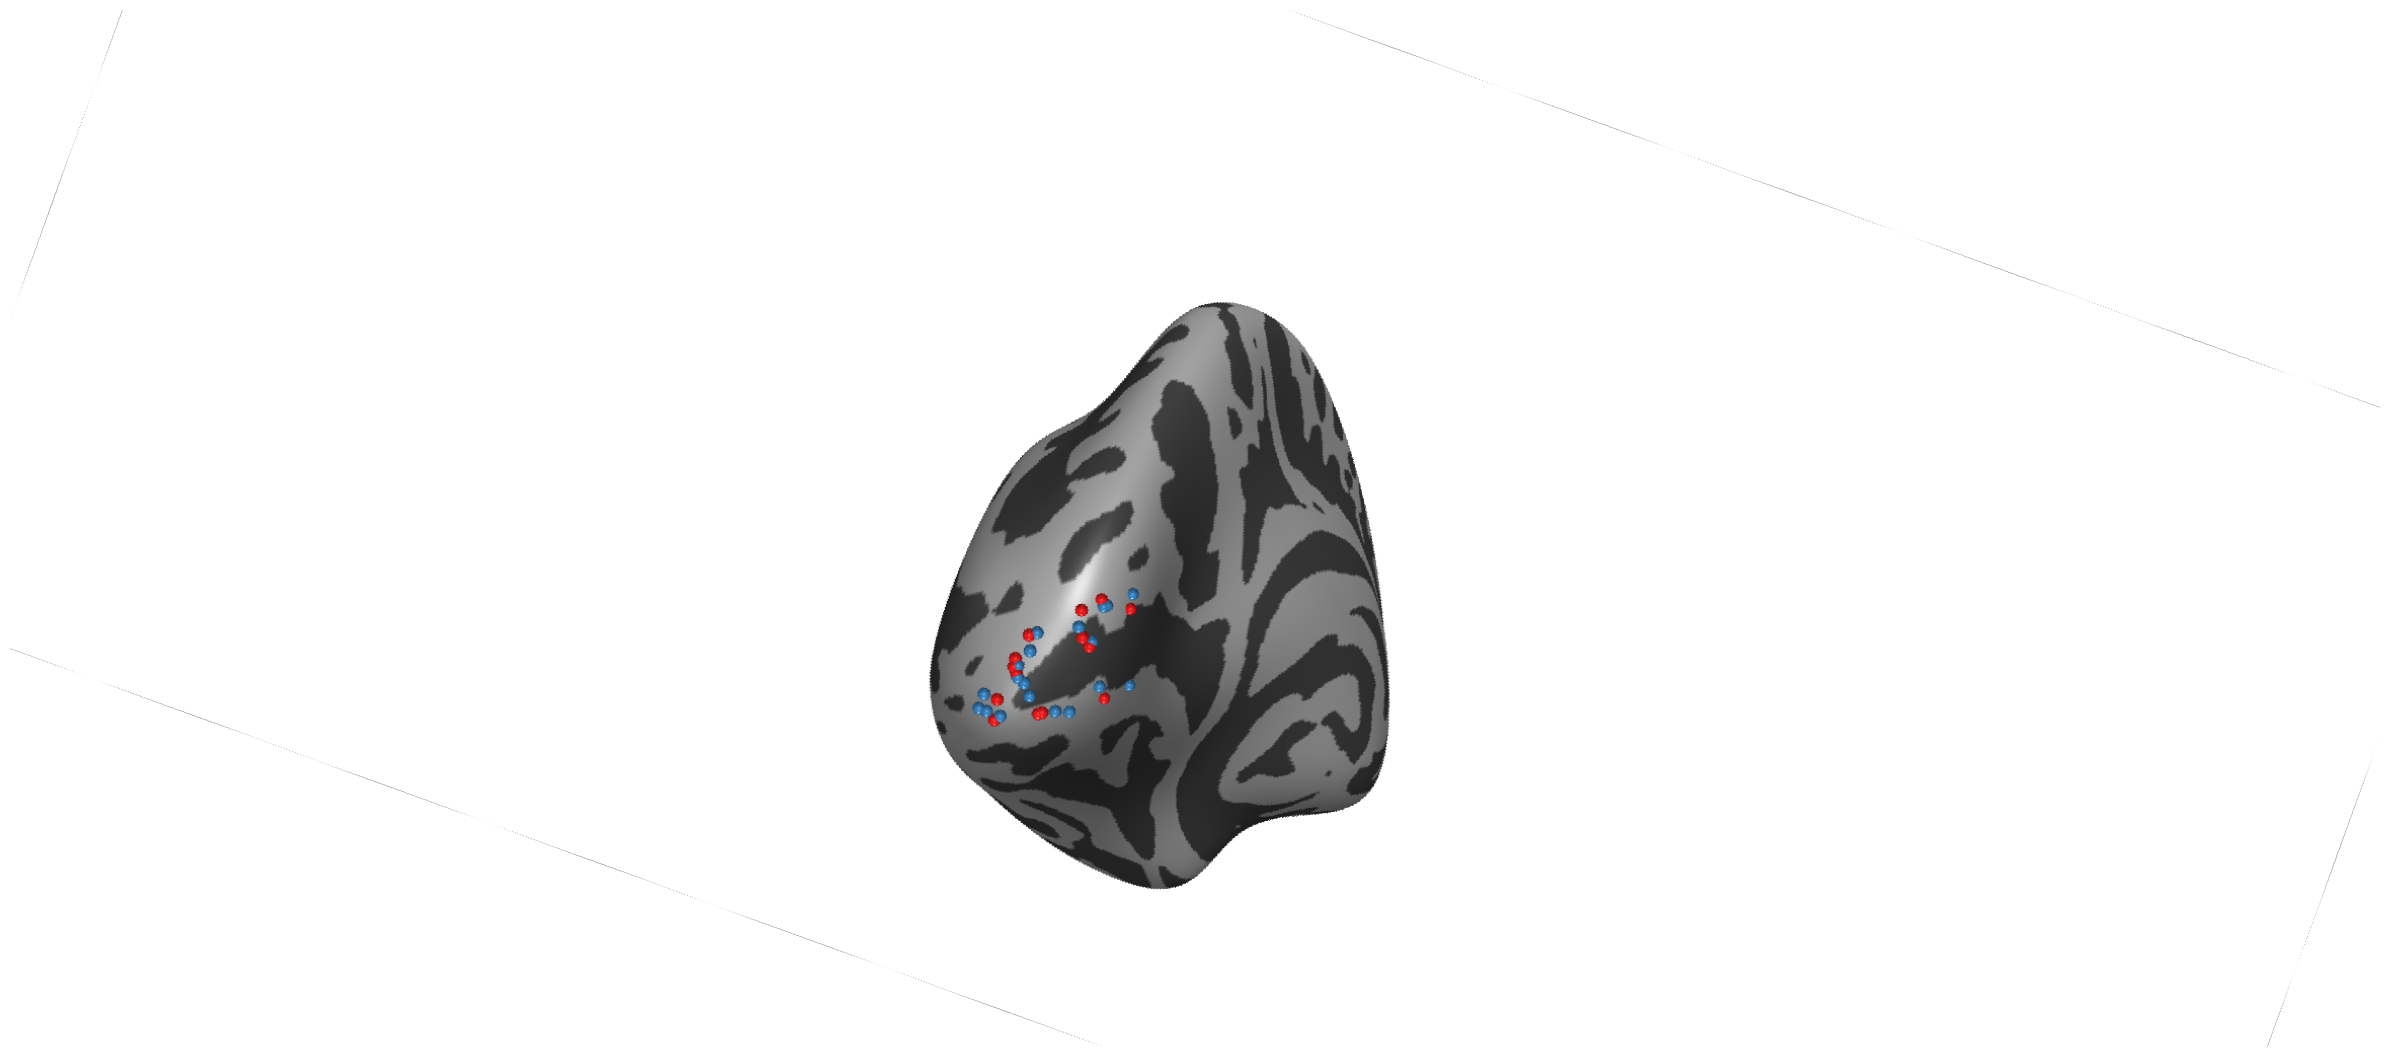

In [13]:
image_data = b64decode(plot_lh.screenshot)

image = Image.open(io.BytesIO(image_data))
rotated_img_left = image.rotate(-20, expand=False)
rotated_array_left = np.array(rotated_img_left)

plt.figure(figsize=(24,16))
plt.imshow(rotated_array_left)
plt.axis("off")
plt.tight_layout()
plt.show()

In [14]:
cam_view_lh = [94, -223, -31, # Left hemisphere
            4, -21, 19.45,
            0.7, -0.9, 0.8]

subj_colors = [
    [228, 26, 28],    # Red
    [55, 126, 184],   # Blue
    [77, 175, 74],    # Green
    [152, 78, 163],   # Purple
    [255, 127, 0],    # Orange
    [255, 255, 51],   # Yellow
    [166, 86, 40],    # Brown
    [247, 129, 191],  # Pink
    [0, 204, 204],    # Cyan/Teal
    [200, 200, 200],  # Light Gray
    [0, 102, 0],      # Dark Green
    [102, 0, 102],    # Magenta/Maroon
    [255, 165, 0],    # Gold/Deep Orange
    [100, 149, 237],  # Cornflower Blue
    [139, 0, 0],      # Dark Red
    [0, 0, 128],      # Navy Blue
    [255, 215, 0],    # Yellow-Gold
    [70, 130, 180],   # Steel Blue
    [210, 105, 30],   # Chocolate Brown
    [0, 128, 0],      # Medium Green
    [255, 0, 255],    # Bright Magenta
    [128, 0, 128],    # Dark Purple
    [255, 20, 147]    # Deep Pink
]

coord_colors=[]
all_coords=[]
for s_idx, subject in enumerate(hi_snr_subjects):
    for coord in subj_coords_lh_ra[subject]:
        all_coords.append(coord)
        coord_colors.append(subj_colors[s_idx])

curv_colors = np.zeros((len(lh_curv_data), 3))
curv_colors[lh_curv_data<=0,:]=166
curv_colors[lh_curv_data>0,:]=64
curv_colors = curv_colors.astype(int)
curv_colors = np.uint32([rgbtoint(i) for i in curv_colors])


plot_subj_lh = show_surface(
    fsave_lh,
    opacity=1, 
    vertex_colors=curv_colors, 
    coords=all_coords,
    coord_size=4,
    coord_color=coord_colors,
    camera_view=cam_view_lh
)


Output()

In [15]:
plot_subj_lh.fetch_screenshot()

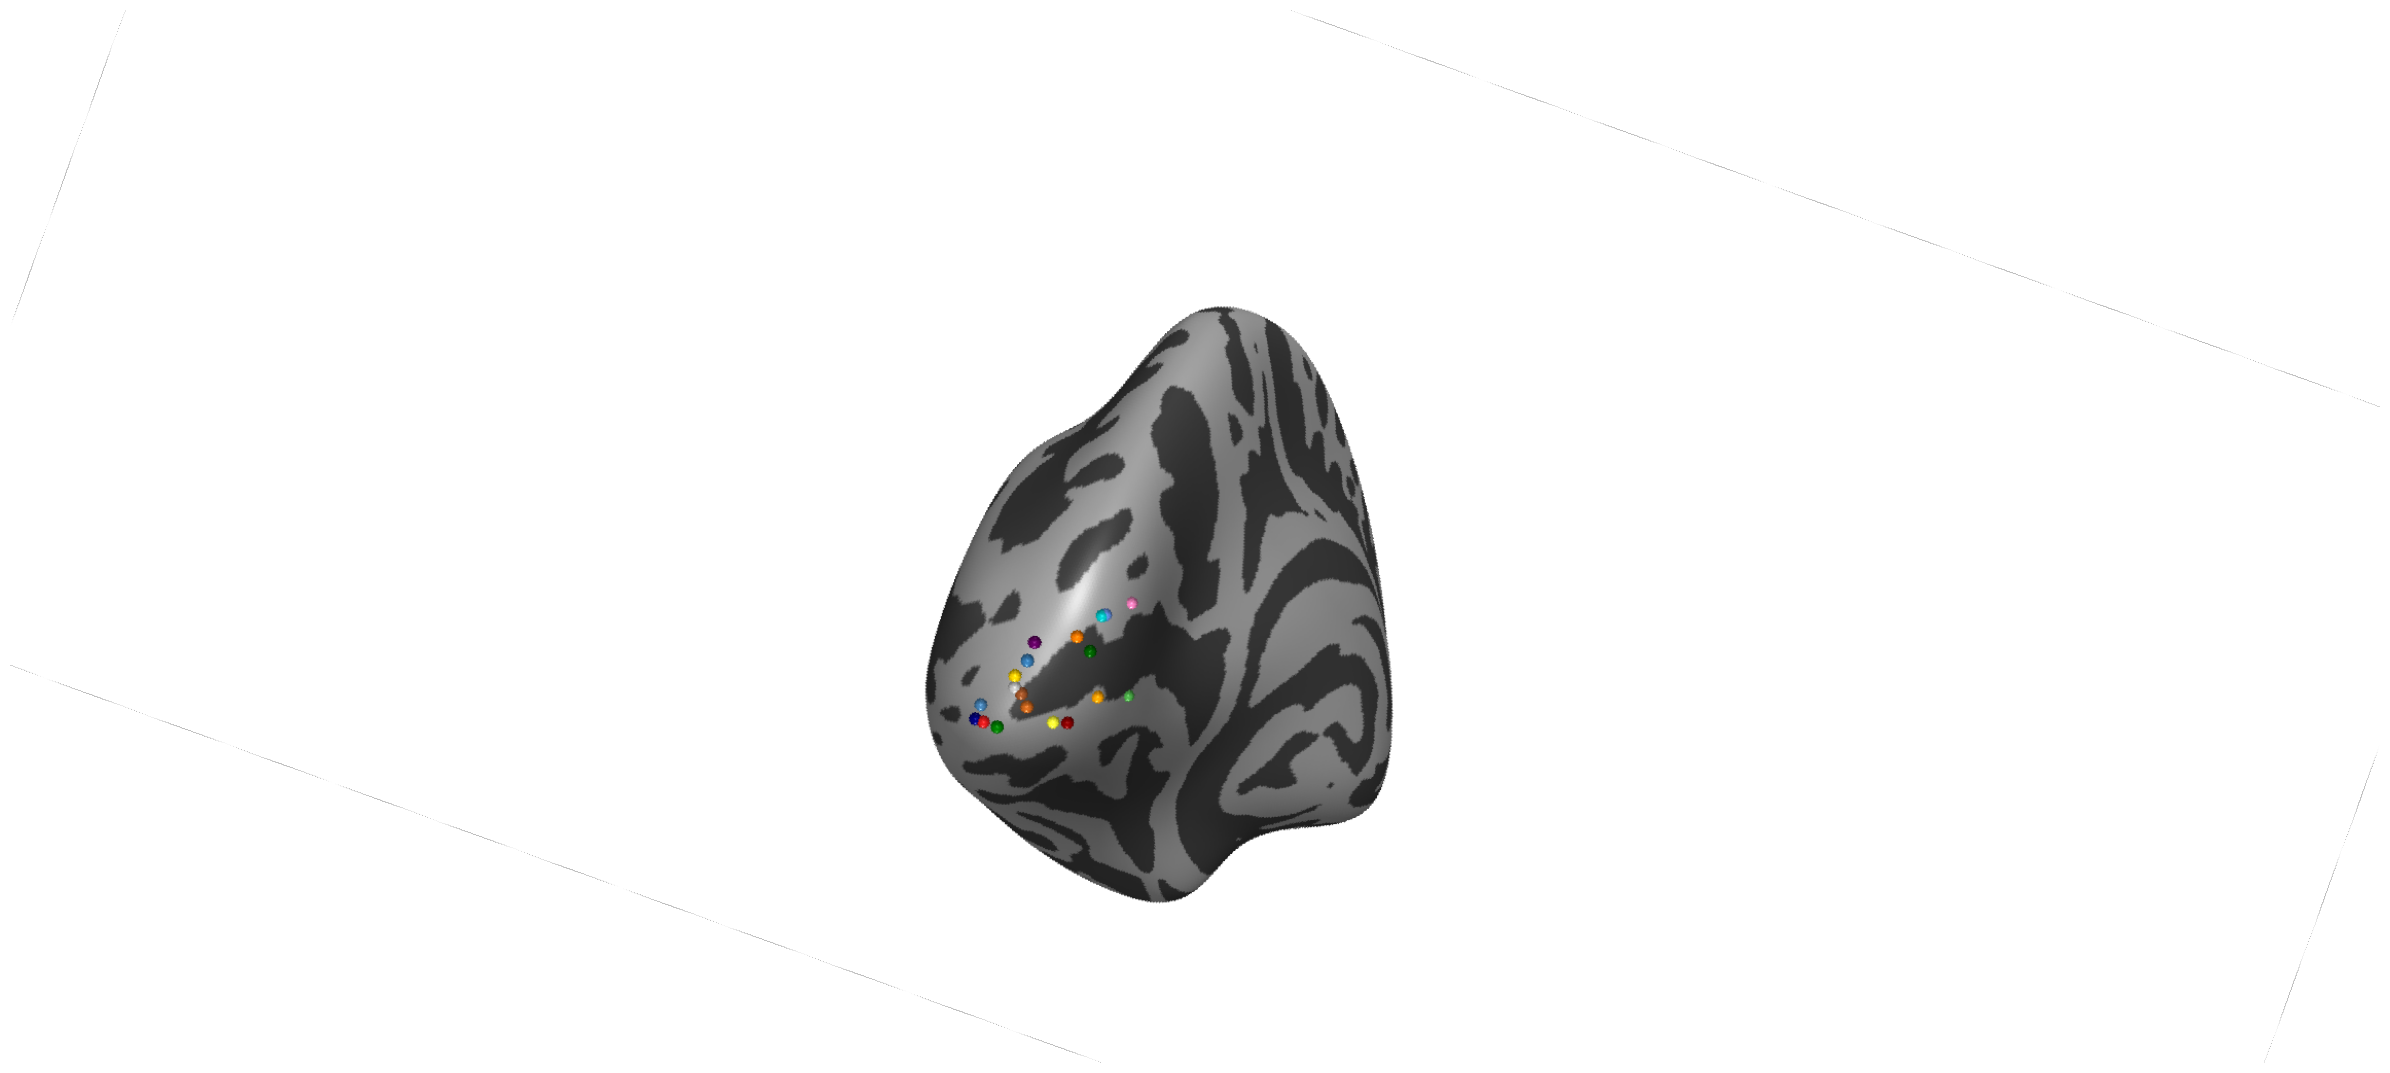

In [16]:
image_data = b64decode(plot_subj_lh.screenshot)

image = Image.open(io.BytesIO(image_data))
rotated_img_left = image.rotate(-20, expand=False)
rotated_array_left = np.array(rotated_img_left)

plt.figure(figsize=(24,16))
plt.imshow(rotated_array_left)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# plot right hemisphere 


fsave_rh_coords, fsave_rh_faces = nib.freesurfer.io.read_geometry('.../fsaverage/surf/rh.inflated')
fsave_rh = create_surf_gifti(fsave_rh_coords, fsave_rh_faces)
rh_curv_data = nib.freesurfer.read_morph_data('.../fsaverage/surf/rh.curv')

subj_coords_rh_la={
    subject: [] for subject in hi_snr_subjects
}

subj_coords_rh_ra={
    subject: [] for subject in hi_snr_subjects
}


for subject in hi_snr_subjects:
        sub_n=subject.split('-')[-1]
        for sess_idx, session in enumerate(sessions[subject]):
            out_fname_left = os.path.join(out_dir,f'results_{subject}_{session}_left_stim.npz')
            out_fname_right = os.path.join(out_dir,f'results_{subject}_{session}_right_stim.npz')
            
            if os.path.exists(out_fname_left and out_fname_right):

                subj_surf_dir=os.path.join(braindyn_files,f'{sub_n}-synth','layer_surf')
                orig_inflated=nib.load(os.path.join(subj_surf_dir, 'inflated.gii'))
                ds_inflated=nib.load(os.path.join(subj_surf_dir, 'inflated.ds.gii'))
                ds_pial = nib.load(os.path.join(subj_surf_dir, 'pial.ds.gii'))

                # right hemisphere left attention
                data = np.load(out_fname_left, allow_pickle=True)
                rh_la_prior = data['rh_prior']
                # right hemisphere right attention
                data = np.load(out_fname_right, allow_pickle=True)
                rh_ra_prior = data['rh_prior']

                rh_la_prior_coord=ds_pial.darrays[0].data[rh_la_prior,:]
                rh_ra_prior_coord=ds_pial.darrays[0].data[rh_ra_prior,:]

                rh_la_hemi, rh_la_fsave_idx = convert_native_to_fsaverage(sub_n +"-synth", subj_surf_dir, subj_coord=rh_la_prior_coord)
                rh_ra_hemi, rh_ra_fsave_idx = convert_native_to_fsaverage(sub_n +"-synth", subj_surf_dir, subj_coord=rh_ra_prior_coord)

                rh_la_fsave_coord = fsave_rh_coords[rh_la_fsave_idx]
                rh_ra_fsave_coord = fsave_rh_coords[rh_ra_fsave_idx]

                if subject not in subj_coords_rh_la or subject not in subj_coords_rh_ra:
                    continue
                
                subj_coords_rh_la[subject].append(rh_la_fsave_coord)
                subj_coords_rh_ra[subject].append(rh_ra_fsave_coord)
            
        if not os.path.exists(out_fname_left and out_fname_right):
            print(f"File does not exist for {subject} {session}")
            continue


In [18]:
cam_view_rh = [-94, -223, -31, # Right hemisphere
            4, -21, -19.45,
            0.7, 0.9, 0.8]


cond_colors = [
    [228, 26, 28],    # Red - ipsi
    [55, 126, 184],   # Blue - contra
]

coord_colors=[]
all_coords=[]
for s_idx, subject in enumerate(hi_snr_subjects):
    for coord in subj_coords_rh_ra[subject]:
        all_coords.append(coord)
        coord_colors.append(cond_colors[0])

for s_idx, subject in enumerate(hi_snr_subjects):
    for coord in subj_coords_rh_la[subject]:
        all_coords.append(coord)
        coord_colors.append(cond_colors[1])

curv_colors = np.zeros((len(rh_curv_data), 3))
curv_colors[rh_curv_data<=0,:]=166
curv_colors[rh_curv_data>0,:]=64
curv_colors = curv_colors.astype(int)
curv_colors = np.uint32([rgbtoint(i) for i in curv_colors])

plot_rh = show_surface(
    fsave_rh,
    opacity=1, 
    vertex_colors=curv_colors, 
    coords=all_coords,
    coord_size=4,
    coord_color=coord_colors,
    camera_view=cam_view_rh
)

Output()

In [19]:
plot_rh.fetch_screenshot()

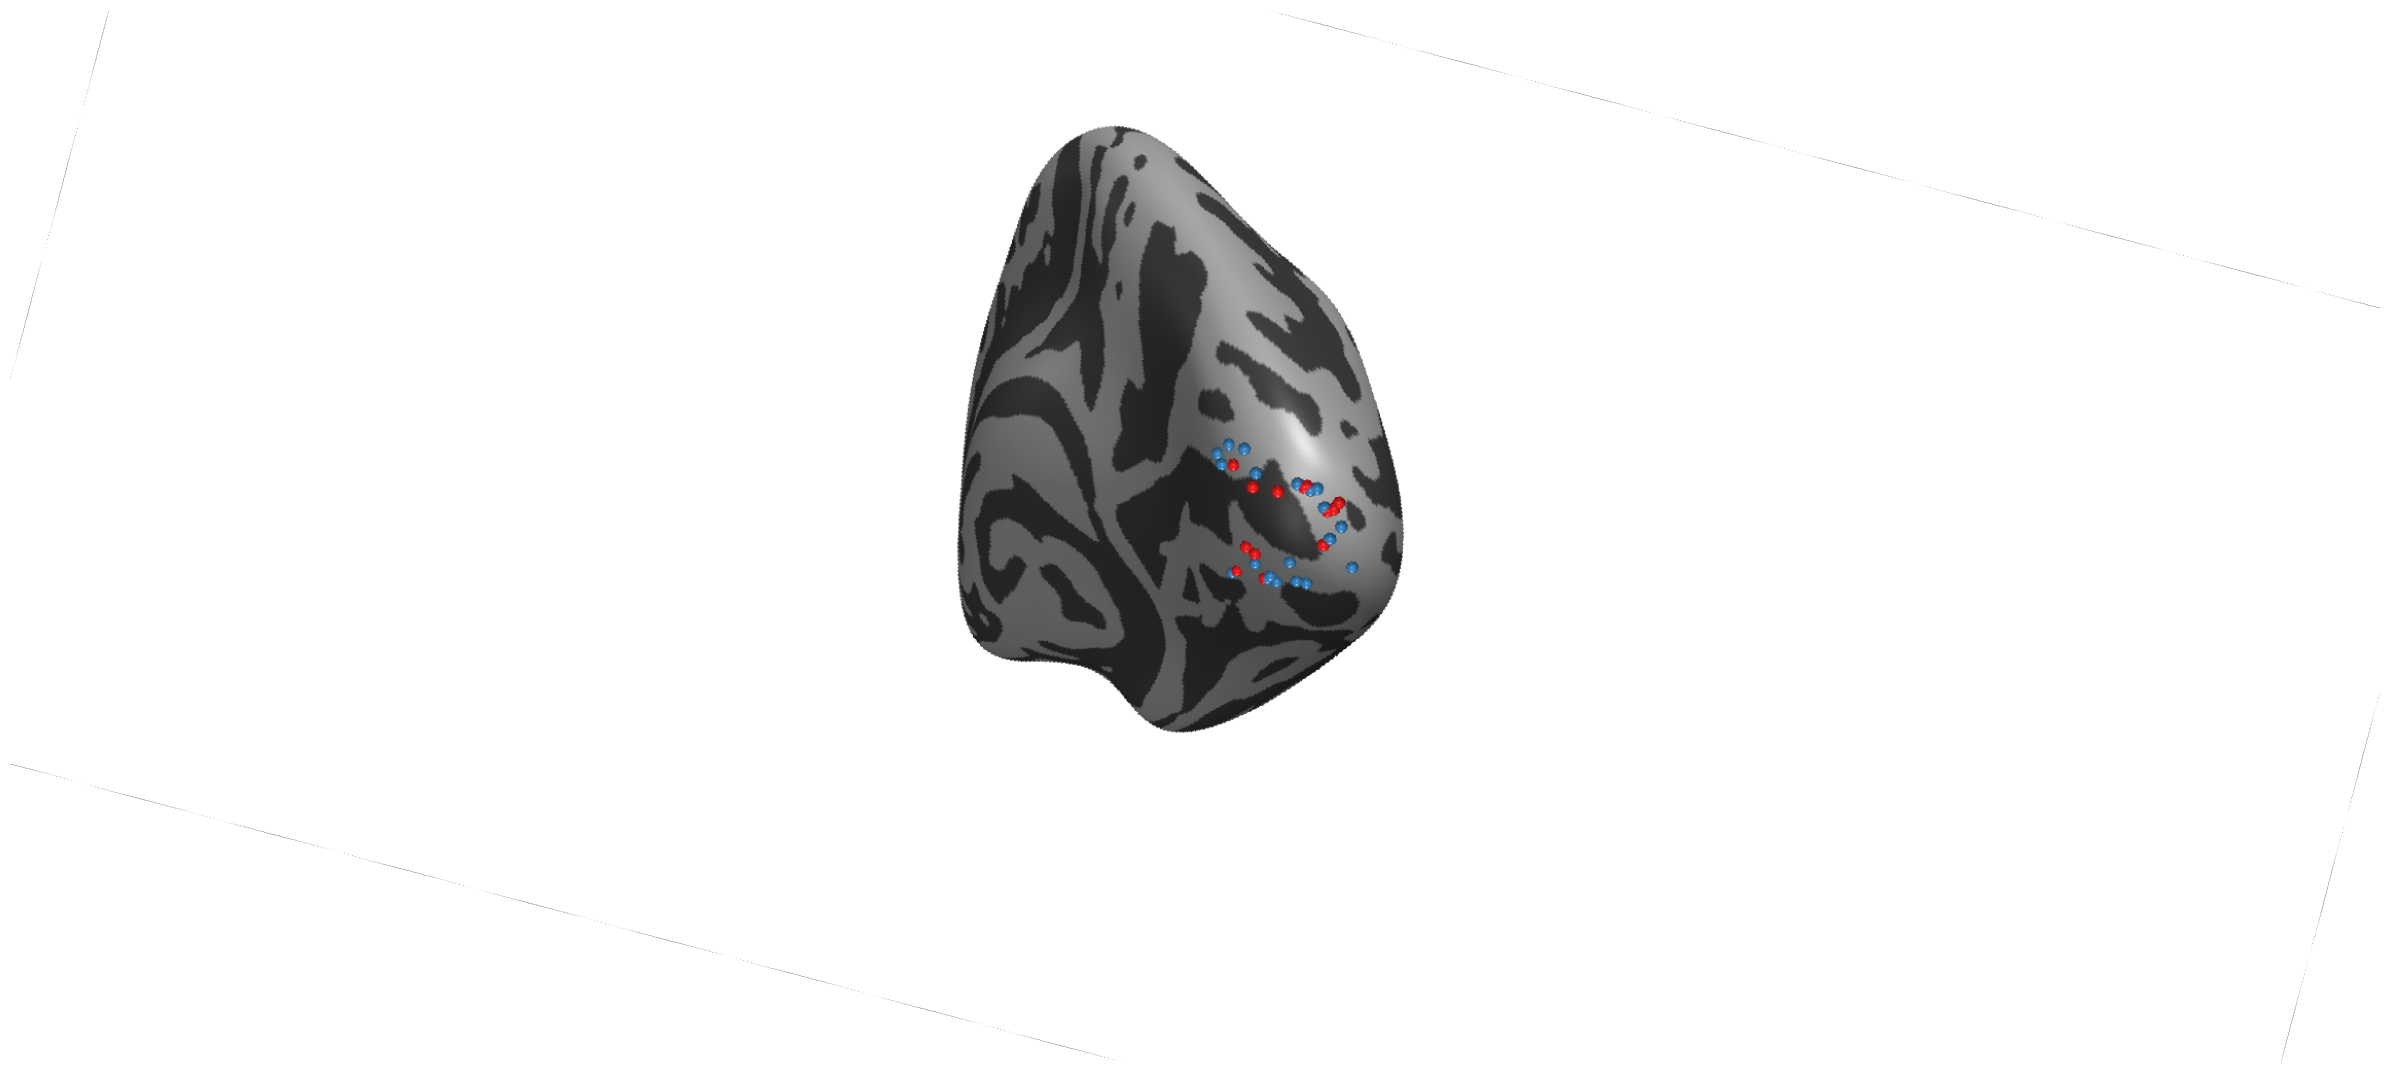

In [20]:
image_data = b64decode(plot_rh.screenshot)

image = Image.open(io.BytesIO(image_data))
rotated_img_right = image.rotate(-15, expand=False)
rotated_array_right = np.array(rotated_img_right)

plt.figure(figsize=(24,16))
plt.imshow(rotated_array_right)
plt.axis("off")
plt.tight_layout()
plt.show()

In [21]:
# plot subjects vertices - contra condition

cam_view_rh = [-94, -223, -31, # Right hemisphere
            4, -21, -19.45,
            0.7, 0.9, 0.8]

subj_colors = [
    [228, 26, 28],    # Red
    [55, 126, 184],   # Blue
    [77, 175, 74],    # Green
    [152, 78, 163],   # Purple
    [255, 127, 0],    # Orange
    [255, 255, 51],   # Yellow
    [166, 86, 40],    # Brown
    [247, 129, 191],  # Pink
    [0, 204, 204],    # Cyan/Teal
    [200, 200, 200],  # Light Gray
    [0, 102, 0],      # Dark Green
    [102, 0, 102],    # Magenta/Maroon
    [255, 165, 0],    # Gold/Deep Orange
    [100, 149, 237],  # Cornflower Blue
    [139, 0, 0],      # Dark Red
    [0, 0, 128],      # Navy Blue
    [255, 215, 0],    # Yellow-Gold
    [70, 130, 180],   # Steel Blue
    [210, 105, 30],   # Chocolate Brown
    [0, 128, 0],      # Medium Green
    [255, 0, 255],    # Bright Magenta
    [128, 0, 128],    # Dark Purple
    [255, 20, 147]    # Deep Pink
]

coord_colors=[]
all_coords=[]

for s_idx, subject in enumerate(hi_snr_subjects):
    for coord in subj_coords_rh_la[subject]:
        all_coords.append(coord)
        coord_colors.append(subj_colors[s_idx])

curv_colors = np.zeros((len(rh_curv_data), 3))
curv_colors[rh_curv_data<=0,:]=166
curv_colors[rh_curv_data>0,:]=64
curv_colors = curv_colors.astype(int)
curv_colors = np.uint32([rgbtoint(i) for i in curv_colors])


plot_subj_rh = show_surface(
    fsave_rh,
    opacity=1, 
    vertex_colors=curv_colors, 
    coords=all_coords,
    coord_size=4,
    coord_color=coord_colors,
    camera_view=cam_view_rh
)


Output()

In [22]:
plot_subj_rh.fetch_screenshot()

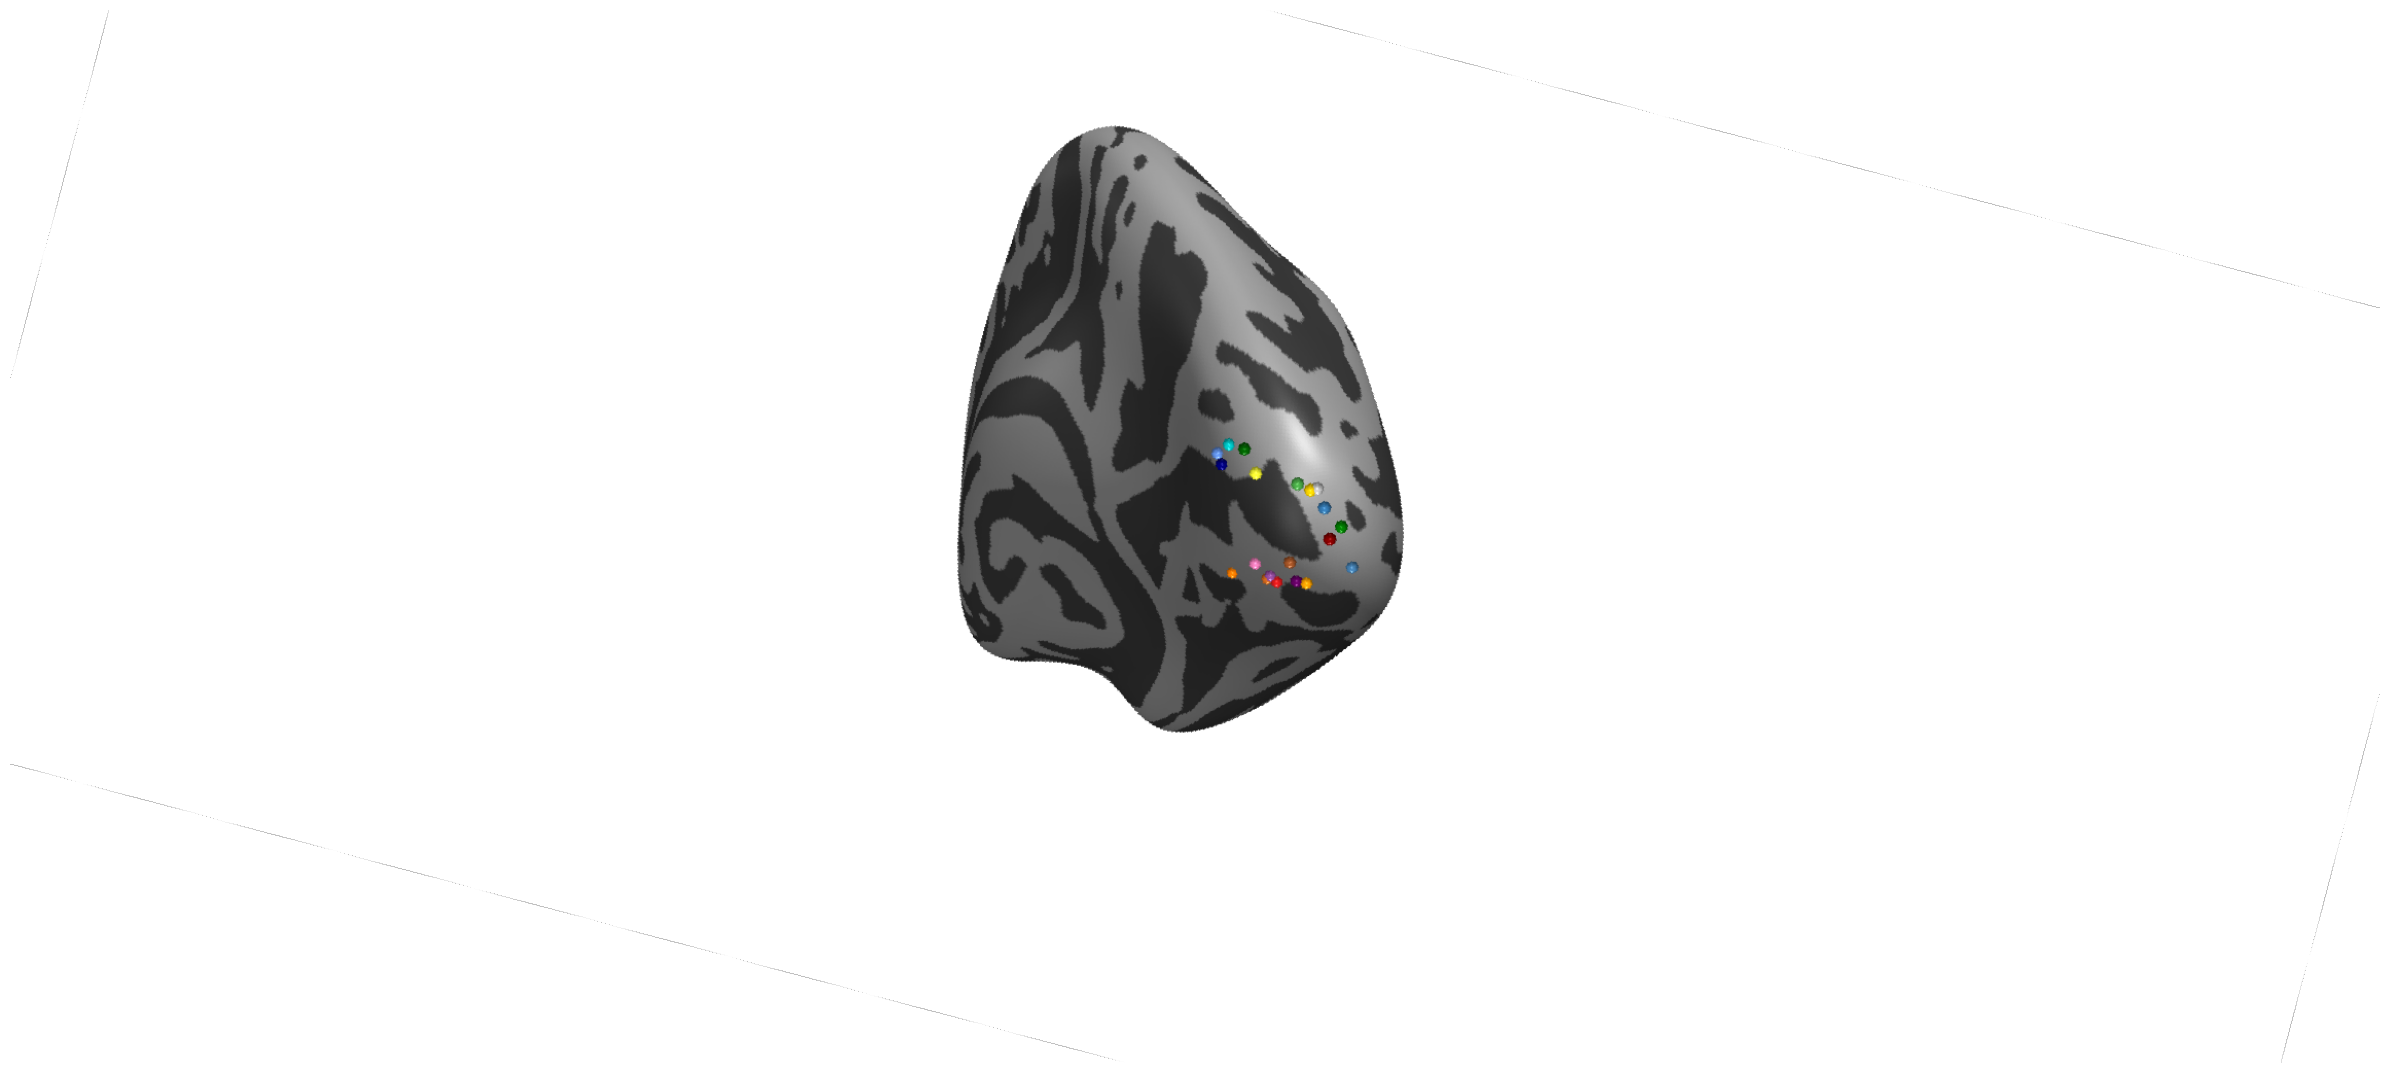

In [23]:
image_data = b64decode(plot_subj_rh.screenshot)

image = Image.open(io.BytesIO(image_data))
rotated_img_right = image.rotate(-15, expand=False)
rotated_array_right = np.array(rotated_img_right)

plt.figure(figsize=(24,16))
plt.imshow(rotated_array_right)
plt.axis("off")
plt.tight_layout()
plt.show()